In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter
import math
from scipy.stats.mstats import gmean
from scipy.stats import gamma, poisson, linregress, beta, norm
from scipy import optimize
from scipy import interpolate
import time
import random
import pickle as pkl
from cratersfd import *
from itertools import product
from matplotlib.patches import Arrow
%matplotlib inline

Set the production function to be a linear function with a slope of -2.0 in cumulative plot log-log space.

In [2]:
pf_slope = -2.0
pf = loglog_linear_pf(N1=0.001, slope=pf_slope)

Set N_array, the array of N values to iterate over.  N_array is evenly spaced in log space but rounded to integer values.

In [3]:
N_array = np.round([10.0**(i) for i in np.arange(1, 4, 0.1)]).astype('int')
synth_area = 10000

Define the list of parameters to search over, as both SlopeSearchParams objects and keys to the dictionaries we use to store the results for different parameter combinations.

In [4]:
params_list = [
    SlopeSearchParams(
        plot_type=plot_type,
        use_uncertainties=use_uncertainties,
        pick_a_side=pick_a_side
    )
    for plot_type in ['unbinned', 'unbinned corrected', 'left']
    for use_uncertainties in [False, True]
    for pick_a_side in [False, True] if 
    use_uncertainties or not pick_a_side
]

key_list = [params.str for params in params_list]
full_key_list = [params.str for params in params_list] + ['mle']

Calculate the slopes for different plotting methods.  Here, we explore three plot types (unbinnned, unbinned corrected, and "binned") and three uncertainty approaches (no uncertainties, with averaged uncertainties, and with the side-picking approach to getting asymmetric uncertainties).  We call the "binned" plot "left" because it samples the cumulative function at the left-hand side of the "bin."  It's traditionally called "binning," but it is more of a sampling.

The scipy curve fitting functions do not allow for asymmetric error bars, so we have to use a workaround.  The first approach is to average the upper and lower bounds (in log space).  The second is the side-picking approach.  For this, we first get an initial slope estimate with the averaged uncertainties.  Then, we pick a side for each point, assigning the appropriate uncertaintes depending on whether the point falls above or below the initial slope estimate.  If any of the points switch sides after the sides have been picked, then we iterate the process until all points are on the correct side.

In variable names, we indicate that uncertainties are used with a u flag, and we indicate that the side-picking is used with a p flag. 

This code takes a long time to run.  For the time-intensive calculations, we have pre-saved files with the results.  These are too large to be uploaded to GitHub.  As a convention, the time-intensive code is inside an if statement set to False.  To execute the code instead of loading pre-saved results from the file, just change False to True.

In [5]:
if False:
    
    if 'slope_list_list_dict' not in locals() and 'slope_list_list_dict' not in globals():
        slope_list_list_dict = {}
    
    for params in params_list:

        t1 = time.time()

        slope_list_list = []
        failure_df_list = []
        switch_list_list = []
        for N in N_array:
            synth_list, synth_age = synth_fixed_N(
                N=N, area=synth_area, pf=pf, dmin=1, 
                dmax=1E5, n_steps=100000
            )
            r_tuple = model_fitting_error(
                synth_list, synth_age, synth_area,
                pf=pf, bin_width_exponent=neukum_bwe, 
                use_uncertainties=params.use_uncertainties,
                plot_type=params.plot_type, 
                skip_zero_crater_bins=True,
                reference_point=1.0, d_min=1.0,
                start_at_reference_point=True,
                n_pseudosteps=100000,
                pick_a_side=params.pick_a_side
            )
            if params.pick_a_side:
                slope_list, switch_list, failure_df = r_tuple
                switch_list_list.append(switch_list)
            else:
                slope_list, failure_df = r_tuple
            slope_list_list.append(slope_list)
            failure_df_list.append(failure_df)

        slope_list_list_dict[params.str] = slope_list_list
        
        with open('saved/slope.' + params.file_str + '.pkl', 'wb') as f:
            pkl.dump(slope_list_list, f)
        with open('saved/failure.' + params.file_str + '.pkl', 'wb') as f:
            pkl.dump(failure_df_list, f)
        if params.pick_a_side:
            with open('saved/switch.' + params.file_str + '.pkl', 'wb') as f:
                pkl.dump(switch_list_list, f)

        t2 = time.time()
        print('runtime: ' + format_runtime(t2 - t1))
        
else:
    
    slope_list_list_dict = {}
    for params in params_list:
        with open('saved/slope.' + params.file_str + '.pkl', 'rb') as f:
            slope_list_list_dict[params.str] = pkl.load(f)

Generate the maximum likelihood estimator results

In [6]:
if False:
    t1 = time.time()
    mle_list = np.array([
        np.array([mle_slope(ds, dmin=1.0) for ds in st[0]])
        for st in N_search_data
    ])
    slope_list_list_dict['mle'] = mle_list
    with open('saved/slope.mle.pkl', 'wb') as f:
        pkl.dump(mle_list, f)
    t2 = time.time()
    print(format_runtime(t2 - t1))
else:
    with open('saved/slope.mle.pkl', 'rb') as f:
        slope_list_list_dict['mle'] = -1 * pkl.load(f)

Fit the slope data to log space normal random variables.

In [7]:
if False:
    t1 = time.time()
    slope_fit_matrix_dict = {
        key : np.array([
            fit_slope_data(slope_list) 
            for slope_list in slope_list_list
        ])
        for key, slope_list_list
        in slope_list_list_dict.items()
    }
    with open('saved/slope_fit_matrix_dict.N_search.pkl', 'wb') as f:
        pkl.dump(slope_fit_matrix_dict, f)
    t2 = time.time()
    print('runtime: ' + format_runtime(t2 - t1))
else:
    with open('saved/slope_fit_matrix_dict.N_search.pkl', 'rb') as f:
        slope_fit_matrix_dict = pkl.load(f)

Fit the max likelihood, lower error bar, and upper error bar data to functions that show how they vary with N.  For the max likelihood, we normalize it by dividing by the true slope to create the max factor.

In [8]:
max_factor_data_dict = {
    key : -1 * 10**slope_fit_matrix[:, 0] / pf_slope
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
max_factor_fit_dict = {
    key : get_fit(fit_eq_max_factor, N_array, 
                  max_factor_data_dict[key]) 
    for key in key_list[:6]
}

lower_data_dict = {
    key : np.log10(slope_fit_matrix[:, 1])
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
lower_fit_dict = {
    key : get_fit(polynomial_degree_5, 
                  np.log10(N_array),
    lower_data_dict[key]) 
    for key in key_list[:6]
}

upper_data_dict = {
    key : np.log10(slope_fit_matrix[:, 2])
    for key, slope_fit_matrix 
    in slope_fit_matrix_dict.items()
}
upper_fit_dict = {
    key : get_fit(polynomial_degree_5, 
                  np.log10(N_array),
                  upper_data_dict[key]) 
    for key in key_list[:6]
}

Set the dictionary of display colors for plotting purposes

In [9]:
cs = ['xkcd:dark sky blue', 'xkcd:vivid blue', 'xkcd:royal blue', 
      'xkcd:light orange', 'xkcd:orange', 'xkcd:dark orange', 
      'xkcd:pink', 'xkcd:pink red', 'xkcd:bright red']

c_dict = {key_list[i] : cs[i] for i in range(len(key_list))}

Plot the data and the fits

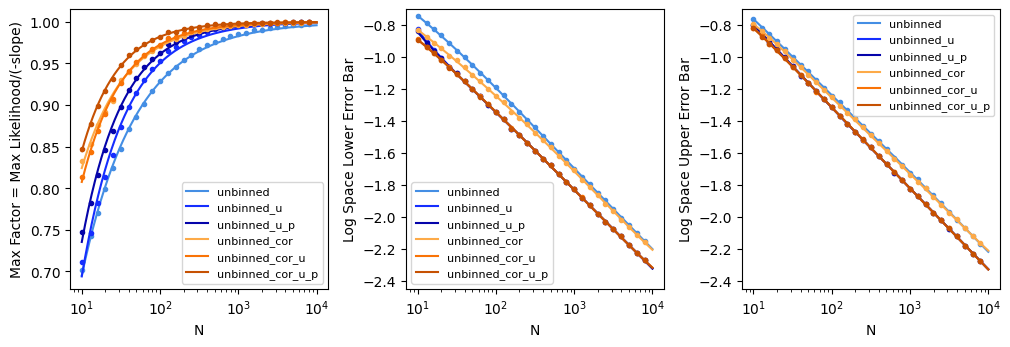

In [10]:
fig = plt.figure(figsize=(12, 8))

ax = plt.subplot(231)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = max_factor_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, max_factor_fit_dict[key].apply(X), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.xlabel('N')
plt.ylabel('Max Factor = Max Likelihood/(-slope)')

ax = plt.subplot(232)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = lower_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, lower_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Lower Error Bar')

ax = plt.subplot(233)

X = np.logspace(1, 4, 500)
for key in key_list[:6]:
    Y = upper_data_dict[key]
    plt.plot(N_array, Y, '.', c=c_dict[key])
    plt.plot(X, upper_fit_dict[key].apply(np.log10(X)), 
             c=c_dict[key], label=key)
plt.legend(fontsize=8)
plt.xscale('log')
plt.ylim([-2.45, -0.7])
plt.xlabel('N')
plt.ylabel('Log Space Upper Error Bar')

fig.subplots_adjust(hspace=0.2, wspace=0.3)